### Introduction to  Gated Recurrent Unit (GRU):
**A Gated Recurrent Unit (GRU), as its name suggests, is a variant of the RNN architecture, and uses gating mechanisms to control and manage the flow of information between cells in the neural network.**

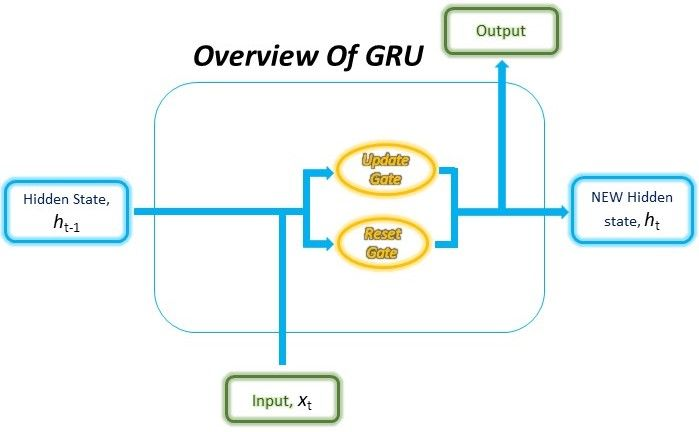

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/gru.jpg')

The GRU cell contains only two gates: `the Update gate` and `the Reset gate`
- Just like the gates in LSTMs, these gates in the GRU are trained to selectively filter out any irrelevant information while keeping what’s useful

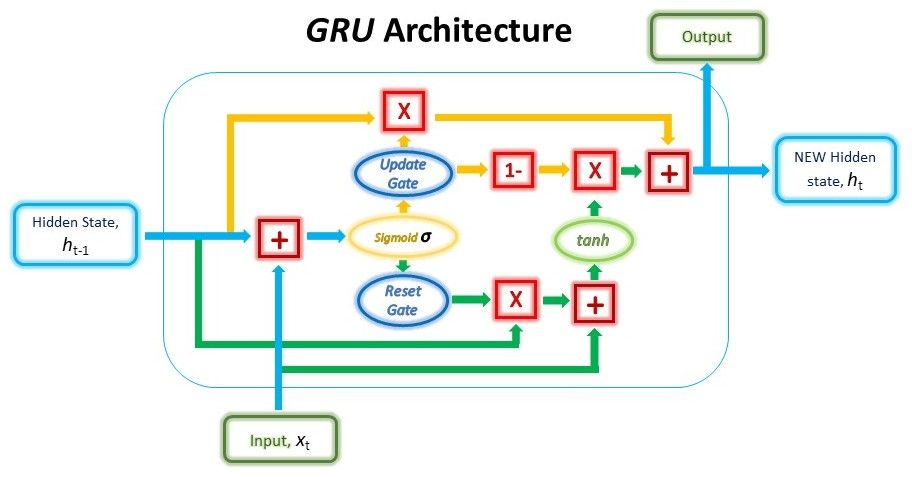

In [25]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/gru_arch.jpg')

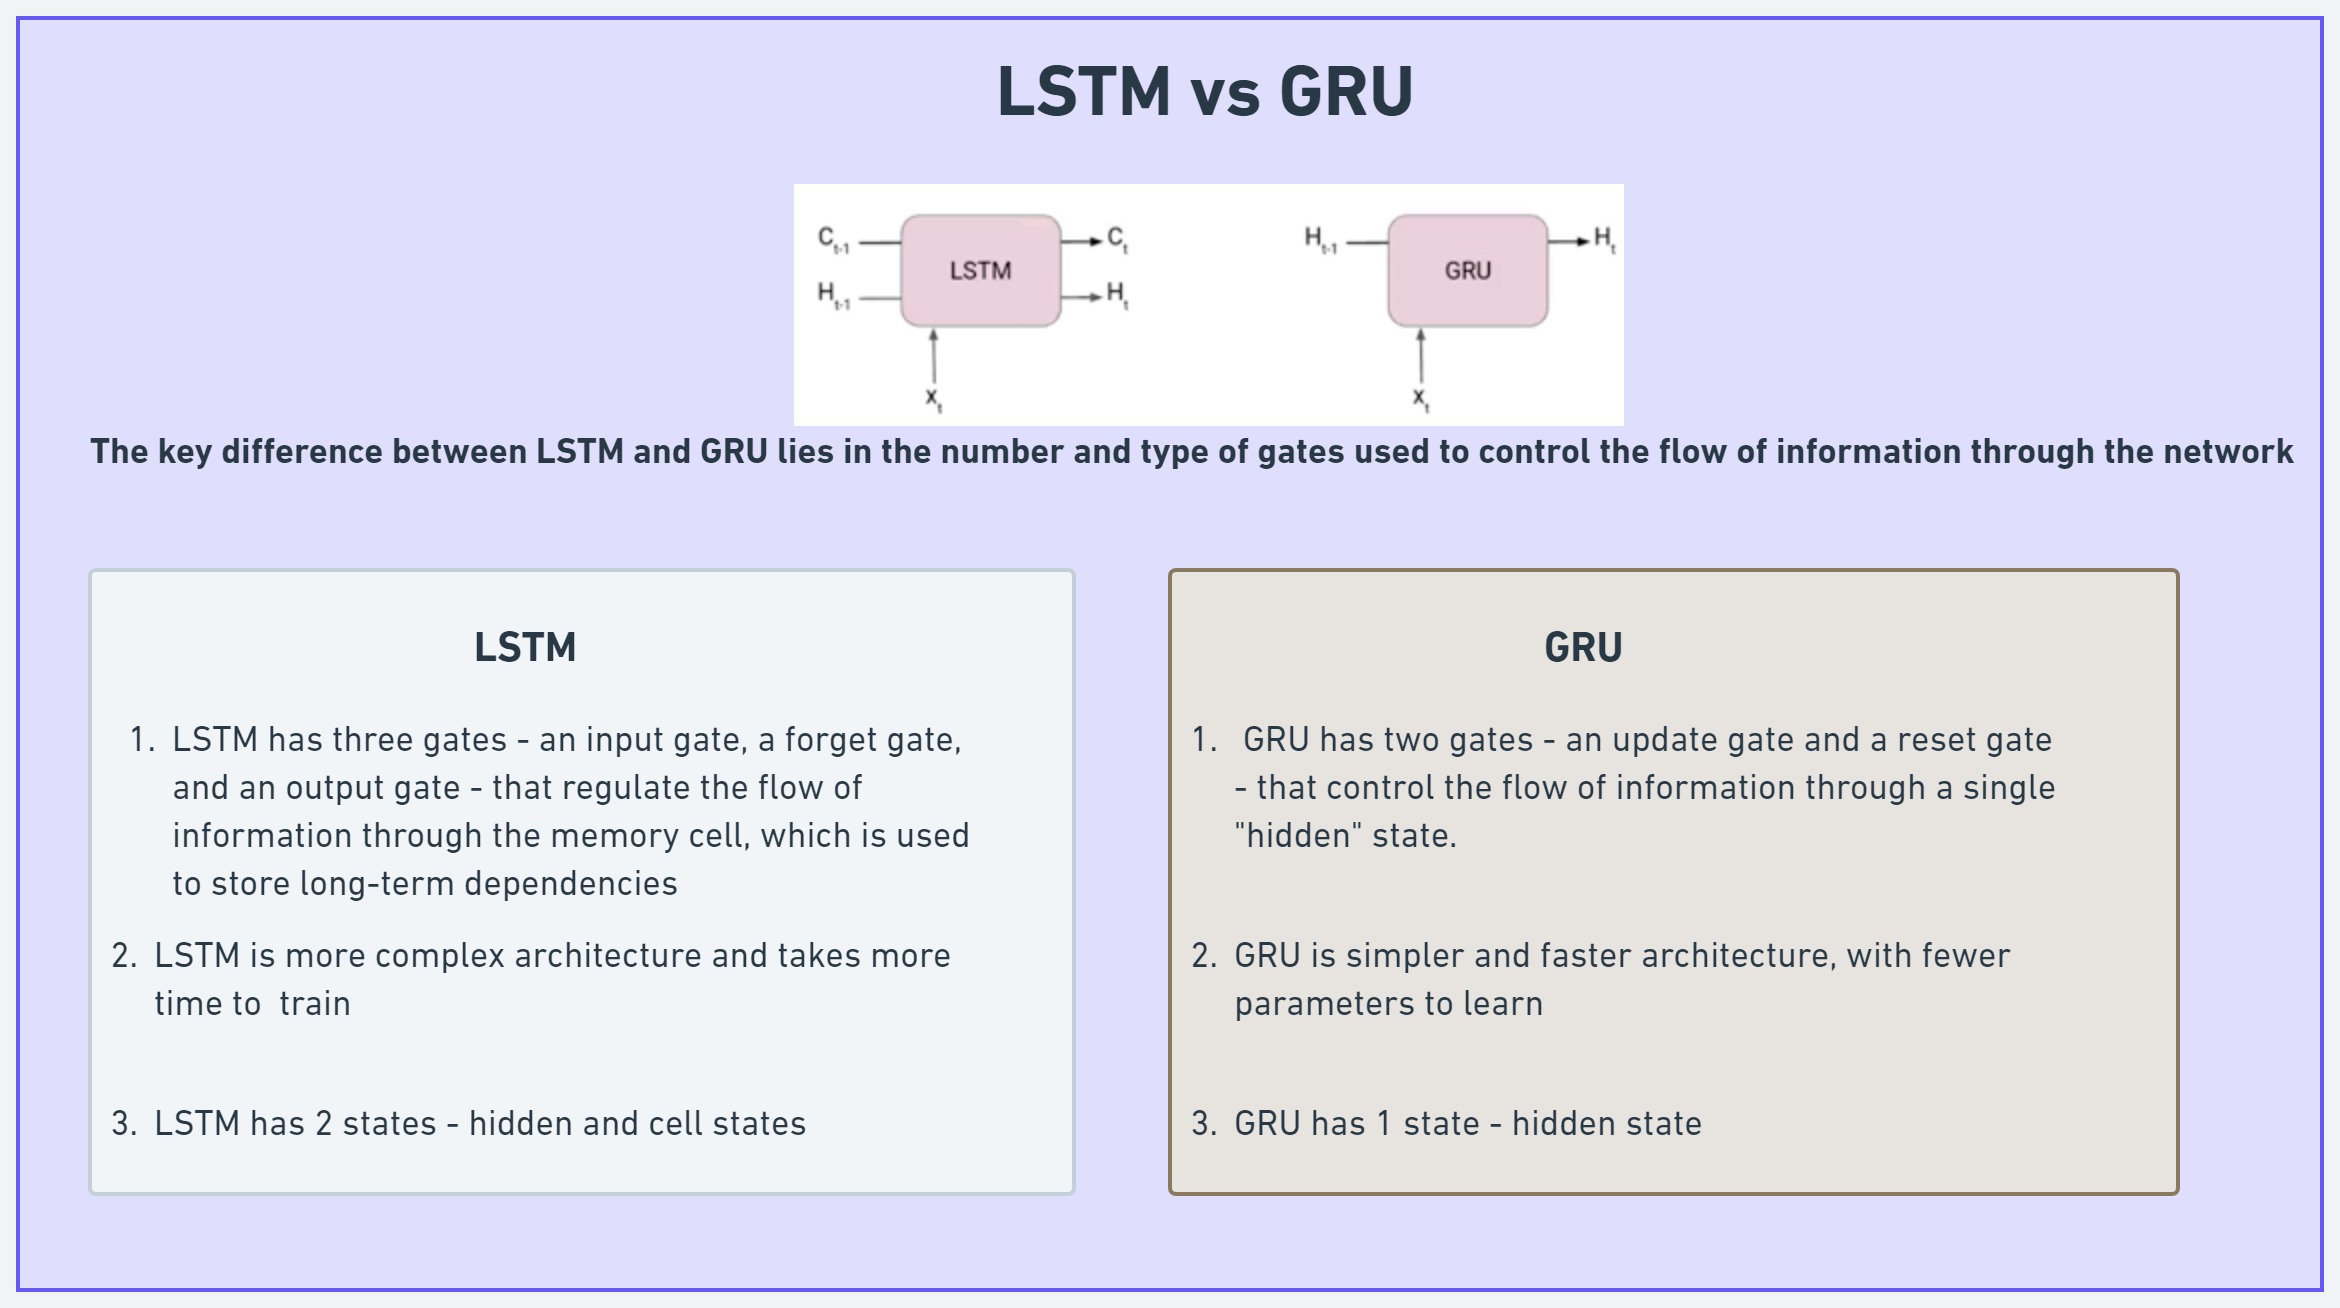

In [24]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/diff.png')

#### Import Libraries 

In [3]:
import spacy
import numpy as np
import math
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import BucketIterator, Field

In [26]:
# We will use seed to get deterministic results
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Download models  ` de_core_news_sm` & `en_core_web_sm` from spacy

In [5]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

#### Create the tokenizer functions

In [6]:
def tokenize_german(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_english(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

#### Field in Torchtext = handle how our data should be processed
- tokenize argument with German being the SRC (source) field and English being the TRG (target) field.
- The field also appends the "start of sequence" and "end of sequence" tokens via the init_token and eos_token arguments, and converts all words to lowercase.

In [7]:
SOURCE = Field(tokenize=tokenize_german, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

TARGET = Field(tokenize = tokenize_english, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

#### Download Multi30k dataset
- exts specifies which languages to use as the source and target (source goes first) and fields specifies which field to use for the source and target.

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SOURCE, TARGET))

#### Build  vocabulary for the source and target languages.
- `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary

In [9]:
SOURCE.build_vocab(train_data,min_freq=2)
TARGET.build_vocab(train_data,min_freq=2)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Create Iterators
- `BucketIterator`  creates batches in such a way that it minimizes the amount of padding in both the source and target sentences.

In [11]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [12]:
class Encoder(nn.Module):
    def __init__(self,input_dim, emb_dim,hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return hidden

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim+hid_dim, hid_dim)
        self.fc = nn.Linear(emb_dim+hid_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp, hidden, context):
        inp = inp.unsqueeze(0)
        embedded = self.dropout(self.embedding(inp))
        em_concate = torch.cat((embedded,context), dim=2)
        output, hidden = self.rnn(em_concate,hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0),context.squeeze(0)), dim=1)
        pred = self.fc(output)
        return pred, hidden

**Seq2Seq**
- For the final part of the implemenetation, we'll implement the seq2seq model.
    - RECEIVING THE INPUT SENTENCE
    - USE ENCODER TO PRODUCE CONTEXT VECTOR
    - USE DECODE TO PROUCE THE PRDICTED SENTENCE 

- The Seq2Seq model takes in an Encoder, Decoder, and a device.
- we have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the Encoder and Decoder.
- Our forward method takes the source sentence, target sentence and a teacher-forcing ratio.
- The first thing we do in the forward method is to create an outputs tensor that will store all of our predictions.
- We then feed the input sentence, into the encoder and receive out final hidden and cell states.

During each iteration of the loop, we:
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
- place our prediction, $\hat{y}_{t+1}$/`output` in our tensor of predictions, $\hat{Y}$/`outputs`
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$/`trg[t]`
    - if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$/`top1`, which we get by doing an `argmax` over the output tensor

In [14]:
class seq2seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions must be Equal"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len,batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        inp = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(inp, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top = output.argmax(1)
            inp = trg[t] if teacher_force else top
        return outputs

#### Training the Seq2Seq Model

In [15]:
INPUT_DIM = len(SOURCE.vocab)
OUTPUT_DIM = len(TARGET.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder  = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
decoder  = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = seq2seq(encoder , decoder , device).to(device)

In [16]:
model

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (fc): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
TRG_PAD_IDX = TARGET.vocab.stoi[TARGET.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        # the loss function only works on 2d inputs with 1d targets we need to flatten each of them with .view
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 21s
	Train Loss: 4.618 | Train PPL: 101.319
	 Val. Loss: 4.304 |  Val. PPL:  74.008
Epoch: 02 | Time: 1m 17s
	Train Loss: 3.608 | Train PPL:  36.901
	 Val. Loss: 3.919 |  Val. PPL:  50.331
Epoch: 03 | Time: 1m 34s
	Train Loss: 3.154 | Train PPL:  23.425
	 Val. Loss: 3.720 |  Val. PPL:  41.269
Epoch: 04 | Time: 1m 29s
	Train Loss: 2.840 | Train PPL:  17.116
	 Val. Loss: 3.633 |  Val. PPL:  37.839
Epoch: 05 | Time: 1m 30s
	Train Loss: 2.603 | Train PPL:  13.506
	 Val. Loss: 3.601 |  Val. PPL:  36.643
Epoch: 06 | Time: 1m 27s
	Train Loss: 2.427 | Train PPL:  11.324
	 Val. Loss: 3.585 |  Val. PPL:  36.055
Epoch: 07 | Time: 1m 33s
	Train Loss: 2.292 | Train PPL:   9.893
	 Val. Loss: 3.532 |  Val. PPL:  34.191


KeyboardInterrupt: 